**NOTE** Run all cells in section 2, then skip to section 5 for imports (all preprocessing is done)

# Business Problem

Pneumonia is a common infection that causes inflammation and possible fluid accumulation in the air sacs of the lungs.


[In China, pneumonia is one of the leading causes of death for children under 5 years old](https://journals.lww.com/md-journal/Fulltext/2018/11160/The_drug_use_to_treat_community_acquired_pneumonia.42.aspx#:~:text=More%20than%202%20million%200,the%20age%20of%205%20years.)


Causes of pneumonia include bactria, virus and fungal sources. 

[Pediatric pneumonia is generally diagnosed based on the time of the year and the results of a physical exam, paying attention the child's breathing and listening to the lungs](https://www.nationwidechildrens.org/conditions/pneumonia). Further testing can include blood tests and chest X-rays. 


Even with modern medicine, pneumonia can be misdiagnosed. A fast and accurate diagnosis allow doctors to treat the infection with the appropirate care. 


One application of machine learning in medicine is digital diagnosis. 


We have been tasked with developing an identification model to determine if a chest X-ray indicates the presence of pneumonia. False negative results are to be minimized compared to false positives.

The data is sourced from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It is already split into three folders for training, validation and testing. All the chest radiographs were screened for quality and diagnostic labeling performed by physicians. The images were collected during routine clinicial care of pediatric patients between one and five years old from Guangzhou Women and Children's Medical Center in Guangzhou, China.

# Imports

In [17]:
import os
from os import listdir
from os.path import isfile, join
import tempfile

from PIL import Image
import math

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras

from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

In [2]:
# os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict
# set figsize for matplotlib
mpl.rcParams['figure.figsize'] = (12, 10)
# set colors for plots
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# EDA

## Helper Functions

Helper functions:
- get_ratio: return the ratio of an 2D image array width:height
- resize_and_crop: returns a scaled and cropped image

In [103]:
def get_ratio(array):
    return array.shape[0]/array.shape[1]

def resize_and_crop(image, new_size=256):
    """
    This function will take in an image, resize and crop it to a square.
    The default new length for a side is 256 pixels.
    The function will output a new square, centered image.
    
    """
    # get width and height from passed image   
    width, height = image.size
    # set up variables for new width and height
    new_width = 0
    new_height = 0
    # calculate the ratio and length of the smaller dimension if the larger moves to the new_size
    if width > height:
        ratio_wh = width / height
        new_width = int(ratio_wh * new_size)
        new_height = new_size
    else:
        ratio_hw = height / width
        new_width = new_size
        new_height = int(ratio_hw * new_size)
    # resize the image
    scaled_image = image.resize((new_width, new_height))
    # if the image is wider, crop in equally from the sides to preserve center of image
    # perform the opposite on images that are taller
    if new_width > new_height:
        # we are only cropping in from left and right, so set top crop to 0 and bottom to new_size
        top = 0
        bottom = new_size
        # set the left and right side crop values
        left = int(math.ceil((new_width - new_size) / 2))
        right = new_width - int(math.floor((new_width - new_size) / 2))
        # crop the image
        cropped_image = scaled_image.crop((left, top, right, bottom))
    else:
        # we are only cropping top and bottom, so set left crop to 0 and right crop to new_size
        left = 0
        right = new_size
        # set the top and bottom crop values
        top = int(math.ceil((new_height - new_size) / 2))
        bottom = new_height - int(math.floor((new_height - new_size) / 2))
        # save the cropped image
        cropped_image = scaled_image.crop((left, top, right, bottom))
    # return the scaled and cropped image
    return cropped_image

## Image size

First, we are going to build a dataframe that contains all the image information for us to look at image sizes.

In [ ]:
folder_names = ['train', 'test', 'val']
label_names = ['NORMAL', 'PNEUMONIA']

all_images = []

# loop through the different combinations of folder name prefixes
for folder in folder_names:
    for label in label_names:
        # set up the path to each folder of images
        path = f'./chest_xray/{folder}/{label}'
        # create a list of the filenames in that directory
        filelist = list(listdir(path))
        # loop through each file in the folder
        for file_name in filelist:
            # set the filepath for the file in question
            filepath = path + r'/' + file_name
            # open the image
            image = Image.open(filepath)
            # convert the few B/W images coded as RGB back to greyscale
            if image.mode == 'RGB':
                image = image.convert('L')
            # convert the image into an array
            image_array = np.asarray(image)
            # get the ratio, height, and width of the image
            ratio = get_ratio(image_array)
            height, width = image_array.shape            
            # append all the image information to the list of images
            all_images.append((folder, label, file_name, ratio, width, height))

# set the column names
column_names = ['folder', 'label', 'file_name', 'ratio', 'width', 'height']
# convert the list of images to a dataframe
all_images_df = pd.DataFrame(all_images, columns=column_names)

In [ ]:
all_images_df.head()

In [ ]:
all_images_df.describe()

For best results in modeling it was advised to scale images to 256x256. We can see that there are some images whose height is below our minimum, lets look a little closer.

In [ ]:
small_images_df = all_images_df[all_images_df.height < 256].copy()

In [ ]:
small_image_count = len(small_images_df)

print(f'There are {small_image_count} images with a dimension under 256.')
print('-------------------------------')
print('Small images occur in the following data/labels:')
display(all_images_df[all_images_df.height < 256].folder.value_counts())
display(all_images_df[all_images_df.height < 256].label.value_counts())

In [ ]:
print('Target distribution in training data')
round(all_images_df[all_images_df.folder == 'train'].label.value_counts(normalize=True)*100, 2)

In [ ]:
percent_small = round(small_image_count / len(all_images_df[(all_images_df.label == "PNEUMONIA") & (all_images_df.folder == 'train')]), 2)
print(f'The {small_image_count} small images represent {percent_small}% of our training data with the pneumonia label')

In [ ]:
small_images_df.ratio.plot(kind='hist');

We can see here that there are only 58 images out of our total 5856 which have a dimension less than our minimum. They are all from training images positive with pneumonia, where we have a large imbalance of that data. Additionally, the ratios of these images are small, meaning that they are significantly wider than they are tall. This would also pose a problem as our images are chest x-rays, and those wider images would likely get cut off when we resize them to square. 

We will not consider these images in modeling so we will drop them from the dataframe.

In [ ]:
images_df = all_images_df.drop(small_images_df.index)
images_df.reset_index(drop=True, inplace=True)

__________________

Since we discovered that the smaller images had very low ratios, let's consider the ratios of the all the rest of the images.

In [ ]:
images_df.ratio.describe()

In [ ]:
images_df.ratio.plot(kind='hist');

Most of our images (75%) have a ratio above 0.63, but the minimum is very low at 0.38. It's suspected that cropping the images that we have with low ratio (which indicates very wide images) may be problematic, so it may be something we have to return to and consider dropping some images with a ratio below a certain threshold. We can do some quick investigation into that.

## Cropping

In [ ]:
def compare_cropping(index_value, df=images_df):
    """
    This helper function will take in the index value of an image in the default
    dataframe: all_images_df. It will display the width, height, and ratio of the
    original with the original image. It will then perform the cropping and display
    the new imaged data along with the new cropped image for comparison.   
    """
    # Get the folder and img_type value from the dataframe to contsruct the folder root
    folder = df.iloc[index_value]['folder']
    label = df.iloc[index_value]['label']
    # constrcut the folder root for the file in question
    root=f"./chest_xray/{folder}/{label}/"
    # set the image path and open the image
    image_path = root + df.iloc[index_value]['file_name']
    image = Image.open(image_path)
    # print the dimensions, ratio, and original image
    print(f"width: {image.width}\theight: {image.height}\tratio: {image.height/image.width}")
    display(image)
    # crop the image
    cropped_image = resize_and_crop(image)
    # print the new image (will be 256x256 with ratio of 1.0)
    display(cropped_image)

Let's look at an image with our 25th percentile value for ratio: 0.63

In [ ]:
compare_cropping(images_df[images_df.ratio == 0.63].index[0])

Here we can see we are losing some of our image on the sides of the chest cavity. We know that data is expensive, so we want to use the most of our images that we can. For arguments' sake, if we were willing to lose the worst 5% of our images based on ratio, let's examine an image with the ratio of the 5% quantile.

In [ ]:
images_df.quantile(q=0.05)

In [ ]:
compare_cropping(images_df[images_df.ratio == 0.55].index[0])

We are definitely losing data by cropping images with ratios this low. Out of curiosity, let's see where most of these images are.

In [ ]:
images_df[images_df.ratio <= 0.55].folder.value_counts()

In [ ]:
images_df[images_df.ratio <= 0.55].label.value_counts()

If we see impact during modeling, we may consider dropping images with ratios less than 0.55 from consideration. Most of the images are from our training set of positive cases (which we have a large majority of).

# Image Preprocessing

Now that we have a dataframe of the raw images data, we need to resize, shrink and convert the images to arrays for modeling. We will do that with a helper function applied to the dataframe and input the arrays into a new feature called 'image_array'.

In [ ]:
def create_image_array(df):
    # set path for image
    path = path = f'./chest_xray/{df.folder}/{df.label}/{df.file_name}'
    # open image
    image = Image.open(path)
    # convert to greyscale
    if image.mode == 'RGB':
        image = image.convert('L')
    # resize and crop the image
    image_modified = resize_and_crop(image)
    # return the image as a numpy array
    return np.asarray(image_modified)

images_df['image_array'] = images_df.apply(create_image_array, axis=1)

We also need to convert the label to a binary value for our target.

In [ ]:
def create_target(df):
    if df.label == 'PNEUMONIA':
        return 1
    else:
        return 0
    
images_df['target'] = images_df.apply(create_target, axis=1)

Now we can set a dataframe for each of our three datasets (train, test and validation)

In [ ]:
train_df = images_df[images_df.folder == 'train'][['image_array', 'target']]
test_df = images_df[images_df.folder == 'test'][['image_array', 'target']]
val_df = images_df[images_df.folder == 'val'][['image_array', 'target']]

Then we split the image_array and target apart, save each datasets' X and y, shuffle the data, and check the shape of each array.

In [ ]:
X_train = np.array(train_df.image_array.values.tolist())
y_train = np.asarray(train_df.target)

X_test = np.array(test_df.image_array.values.tolist())
y_test = np.asarray(test_df.target)

X_val = np.array(val_df.image_array.values.tolist())
y_val = np.asarray(val_df.target)

# helper function to shuffle data/target in the same way
def shuffle_arrays(data, target):
    assert len(data) == len(target)
    p = np.random.permutation(len(data))
    return data[p], target[p]
# shuffle all data
X_train, y_train = shuffle_arrays(X_train, y_train)
X_val, y_val = shuffle_arrays(X_val, y_val)
X_test, y_test = shuffle_arrays(X_test, y_test)

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

Now we need to reshape the arrays to feed into our models

In [ ]:
# set the lengths of each set of data
train_len = X_train.shape[0]
test_len = X_test.shape[0]
val_len = X_val.shape[0]

# set the new reshape size for the images
img_size = X_train.shape[1] ** 2

# reshape all three data groups
X_train = X_train.reshape(train_len, img_size).astype('float32')
X_test = X_test.reshape(test_len, img_size).astype('float32')
X_val = X_val.reshape(val_len, img_size).astype('float32')

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

We are going to save these arrays so we don't have to perform all this processing when reloading the notebook, we can skip right to loading the data already prepared.

In [ ]:
# set the data path
data_path = f"./data/"
# list of variables we are saving
datasets = ['X_train', 'y_train', 'X_test', 'y_test', 'X_val', 'y_val']

for dataset in datasets:
    np.save(file=f'{data_path}{dataset}.npy', arr=globals()[dataset])

# Loading Data

In [3]:
# set the data path and get the list of files
data_path = f"./data/"
data_files = list(listdir(data_path))

for file in data_files:
    # split off the components of the file name
    dataset = file[:-4]
    # set a global variable for each file with that files name and the data from the file
    globals()[f"{dataset}"] = np.load(data_path + file)

# normalize the data
X_train /= 255.
X_val /= 255.
X_test /= 255.

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

Train data/target shapes: (5158, 65536), (5158,)
Test data/target shapes: (624, 65536), (624,)
Val data/target shapes: (16, 65536), (16,)


# Modeling helpers

## Global Variables

In [4]:
# setting up training data class imbalance for eventual weighting
neg, pos = np.bincount(y_train)
total = neg+pos

percent_neg = round(neg/total*100, 2)
percent_pos = round(pos/total*100, 2)

print(f'Training data contains:\nTotal: {total}\nNegative: {neg} ({percent_neg}%)\nPositive: {pos} ({percent_pos}%)')

Training data contains:
Total: 5158
Negative: 1341 (26.0%)
Positive: 3817 (74.0%)


In [5]:
# setting up metrics for model comparison
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'), # using binary accuracy
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

## Helper Functions

In [6]:
def set_x_y():
    # get user input for testing dataset
    print("Choose which testing dataset to use for reporting")
    print("Input S for training data\nInput T for test data\nInput V for validation data:")
    test_choice = input()
    # set the correct global datasets to the local X_test and y_test for reporting
    if test_choice.lower() == 's':
        X_test, y_test = globals()['X_train'], globals()['y_train']
    elif test_choice.lower() == 't':
        X_test, y_test = globals()['X_test'], globals()['y_test']
    else:
        X_test, y_test = globals()['X_val'], globals()['y_val']
    # return the test target and label
    return X_test, y_test

def converted_ypred(model, X_test, threshold=0.5):
    # generate predictions
    y_pred = model.predict(X_test)
    # convert the predictions based on the threshold
    # default is: 0.5
    converted_ypred = []
    for i in range(len(y_pred)):
        if y_pred[i][0] > threshold:
            converted_ypred.append(1)
        else:
            converted_ypred.append(0)
    # return the converted y_preds as an array
    return np.asarray(converted_ypred)

def model_report(y_test, y_pred):
    # set up labels for classifcation report and confution matrix
    report_labels = ['normal', 'pneumonia']
    column_labels = ['predicted normal', 'predicted pneumonia']
    index_labels = ['actual normal', 'actual pneumonia']
    # generate the confusion matrix
    cmatrix = confusion_matrix(y_test, y_pred)
    # convert into dataframe
    cmatrix_df = pd.DataFrame(cmatrix, columns=column_labels, index=index_labels)
    print('---------------------------------------------------------------\n')
    # print the classification report
    print(classification_report(y_test, y_pred, zero_division=0, target_names=report_labels))
    # show report as heatmap   
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(data=cmatrix_df, annot=True, cmap='Blues', fmt='g')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

def plot_metrics(results):
    # set the history
    history = results.history
    # set up metrics to plot
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    # set up x-axis (number of epochs)
    epochs = list(range(1, len(history['loss'])+1))
    # generate plot for each of the 4 metrics in a 2x2 plot
    plt.figure(figsize=(15,15))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(epochs, history[metric], color=colors[0], label='Train')
        plt.plot(epochs, history['val_'+metric], color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0,1.1])
    plt.legend();    

def full_report(model, results):
    # set the X_train and y_train
    X_train, y_train = globals()['X_train'], globals()['y_train']
    # set the testing X and y based on input
    X_test, y_test = set_x_y()
    # create the y_pred 
    y_pred = converted_ypred(model, X_test)   
    # print the model report and confusion matrix
    model_report(y_test, y_pred)
    # display the 2x2 plot of metrics  
    plot_metrics(results)

# Baseline - MLP model

Inspiration from TensorFlow Tutorial to enact some changes to process and account for imbalanced data. [Source](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
def make_baseline_model():
       
    # set up model
    model = keras.Sequential()
    model.add(Dense(128, activation='relu', input_shape = (X_train.shape[-1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=METRICS)

    return model

In [ ]:
baseline_model = make_baseline_model()
baseline_model.summary()

In [ ]:
EPOCHS = 5
BATCH_SIZE = 30

baseline_results = baseline_model.fit(X_train, y_train,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      class_weight=dict(enumerate(class_weights)),
                                      validation_data=(X_val, y_val))

In [ ]:
full_report(baseline_model, baseline_results)

This doesn't look great. Our model accuracy is at 74% and steady, and the validation is at 50%. Unsurprisingly, these are the percentages of our data that are labeled with pneumonia (74% for training, 50% for validation). 

# CNN

### Correcting data shape

In [12]:
# set up the X train/test/val for CNNs
X_train = X_train.reshape(len(X_train), 256, 256, 1)
X_val = X_val.reshape(len(X_val), 256, 256, 1)
X_test = X_test.reshape(len(X_test), 256, 256, 1)

# verify shapes are accurate
print(f"Train data/target shapes: {X_train.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val.shape}, {y_val.shape}")

Train data/target shapes: (5158, 256, 256, 1), (5158,)
Test data/target shapes: (624, 256, 256, 1), (624,)
Val data/target shapes: (16, 256, 256, 1), (16,)


### Callbacks

In [30]:
# we are going to employ a patience of 2 for early stopping
early_stopping = EarlyStopping(patience=2)

### Class Weighting

In [20]:
classes = list(np.unique(y_train))
weights = list(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train))
class_weights = dict(zip(classes, weights))
class_weights

{0: 1.9231916480238629, 1: 0.675661514278229}

## CNN model v1

For the first CNN model, we will use 3 layers of convolution, starting with 32 filters and doubling each layer.

Activations other than output will use relu, output uses sigmoid activation.

We will use binary crossentropy as the loss, adam ast he optimizer, and the list of metrics defined in 6.1

In [33]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v1 = make_cnn_model()
cnn_model_v1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 30, 30, 128)     

In [34]:
EPOCHS = 10
BATCH_SIZE = 128

cnn_model_v1_results = cnn_model_v1.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 194s 5s/step - loss: 0.5767 - tp: 3422.0000 - fp: 694.0000 - tn: 655.0000 - fn: 403.0000 - accuracy: 0.7880 - precision: 0.8314 - recall: 0.8946 - auc: 0.7881 - prc: 0.8815 - val_loss: 0.4529 - val_tp: 7.0000 - val_fp: 3.0000 - val_tn: 5.0000 - val_fn: 1.0000 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750 - val_auc: 0.9219 - val_prc: 0.9283
Epoch 2/10
41/41 [==============================] - 192s 5s/step - loss: 0.1655 - tp: 3681.0000 - fp: 183.0000 - tn: 1158.0000 - fn: 136.0000 - accuracy: 0.9382 - precision: 0.9526 - recall: 0.9644 - auc: 0.9771 - prc: 0.9912 - val_loss: 0.4944 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 0.8750 - val_prc: 0.8723
Epoch 3/10
41/41 [==============================] - 198s 5s/step - loss: 0.1374 - tp: 3686.0000 - fp: 136.0000 - tn: 1205.0000 - fn: 131.0000 - accuracy: 0.9482 - 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.97      0.31      0.47       234
   pneumonia       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624



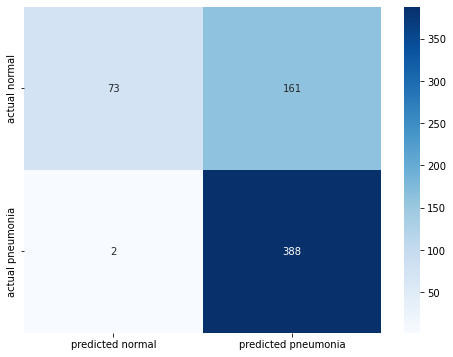

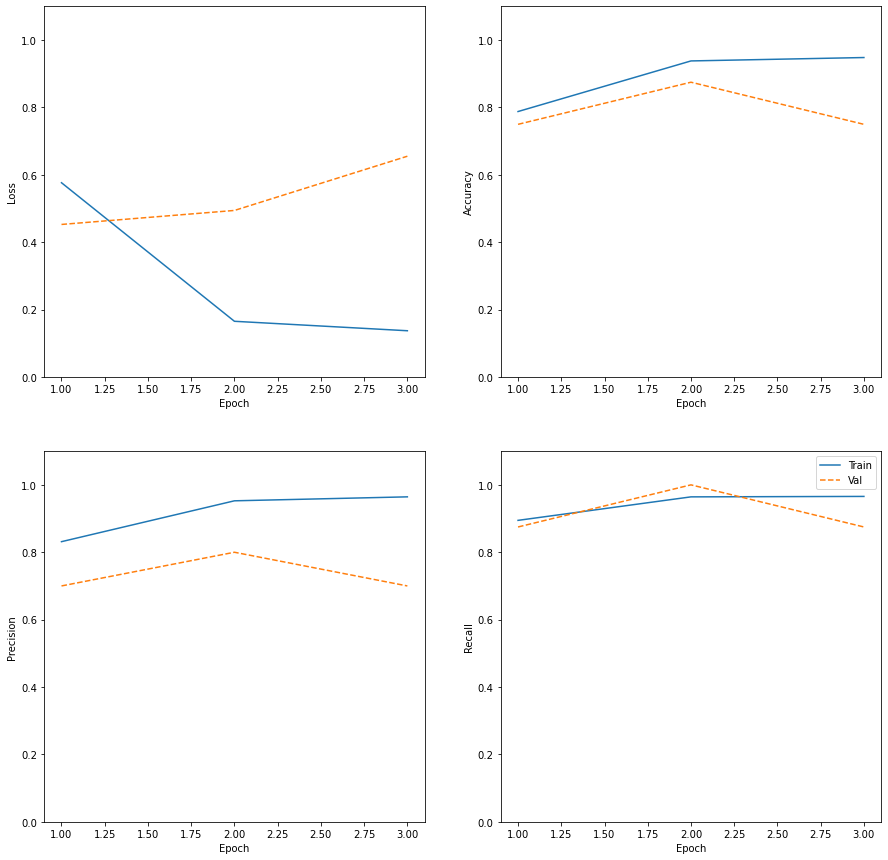

In [35]:
full_report(cnn_model_v1, cnn_model_v1_results)

## CNN model v2

Adding another convolution layer with 64 filters

In [37]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))    
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v2 = make_cnn_model()
cnn_model_v2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 30, 30, 64)     

In [38]:
EPOCHS = 10
BATCH_SIZE = 128

cnn_model_v2_results = cnn_model_v2.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 187s 5s/step - loss: 0.4133 - tp: 3710.0000 - fp: 814.0000 - tn: 535.0000 - fn: 115.0000 - accuracy: 0.8204 - precision: 0.8201 - recall: 0.9699 - auc: 0.8276 - prc: 0.9283 - val_loss: 0.9264 - val_tp: 8.0000 - val_fp: 7.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - val_auc: 0.9219 - val_prc: 0.9283
Epoch 2/10
41/41 [==============================] - 188s 5s/step - loss: 0.1635 - tp: 3688.0000 - fp: 197.0000 - tn: 1144.0000 - fn: 129.0000 - accuracy: 0.9368 - precision: 0.9493 - recall: 0.9662 - auc: 0.9783 - prc: 0.9920 - val_loss: 0.9746 - val_tp: 8.0000 - val_fp: 6.0000 - val_tn: 2.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.9062 - val_prc: 0.8392
Epoch 3/10
41/41 [==============================] - 193s 5s/step - loss: 0.1761 - tp: 3638.0000 - fp: 179.0000 - tn: 1162.0000 - fn: 179.0000 - accuracy: 0.930

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.97      0.32      0.48       234
   pneumonia       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624



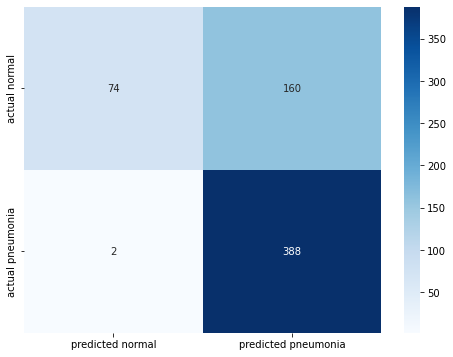

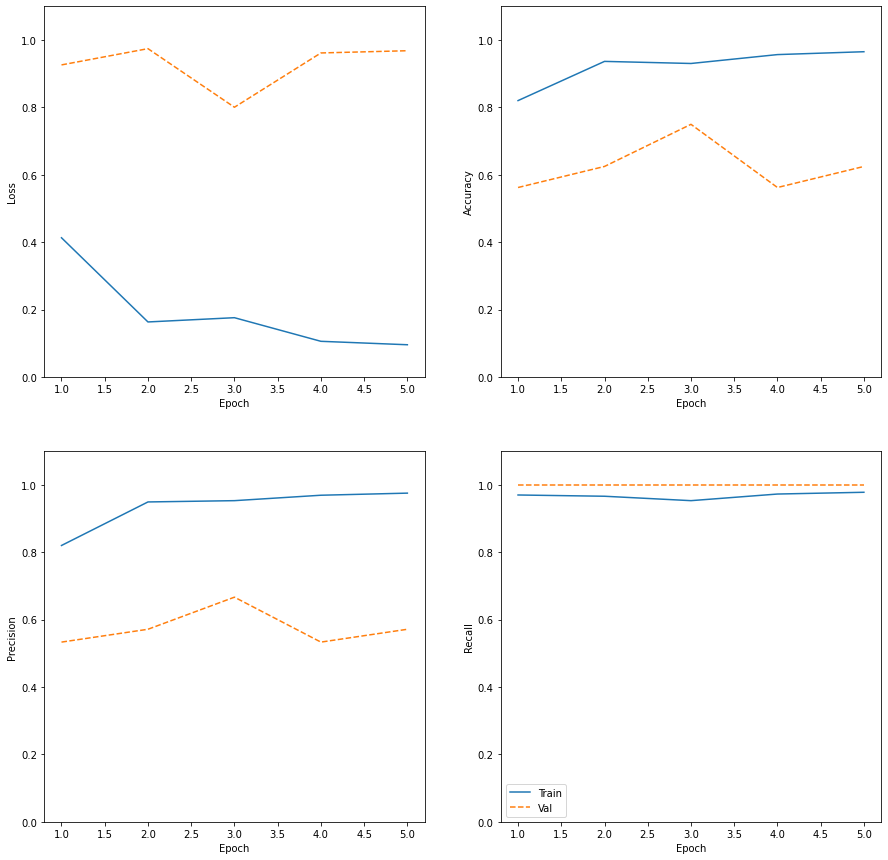

In [39]:
full_report(cnn_model_v2, cnn_model_v2_results)

## CNN model v3

Increasing the number of nodes after flattening, and adding in class weighting (calculated in 8.0.3)

In [42]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))    
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v3 = make_cnn_model()
cnn_model_v3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 30, 30, 64)     

In [43]:
EPOCHS = 10
BATCH_SIZE = 128

cnn_model_v3_results = cnn_model_v3.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 183s 4s/step - loss: 0.4620 - tp: 2650.0000 - fp: 285.0000 - tn: 1064.0000 - fn: 1175.0000 - accuracy: 0.7178 - precision: 0.9029 - recall: 0.6928 - auc: 0.8543 - prc: 0.9410 - val_loss: 0.2603 - val_tp: 6.0000 - val_fp: 1.0000 - val_tn: 7.0000 - val_fn: 2.0000 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500 - val_auc: 0.9688 - val_prc: 0.9686
Epoch 2/10
41/41 [==============================] - 178s 4s/step - loss: 0.2225 - tp: 3446.0000 - fp: 106.0000 - tn: 1235.0000 - fn: 371.0000 - accuracy: 0.9075 - precision: 0.9702 - recall: 0.9028 - auc: 0.9709 - prc: 0.9893 - val_loss: 0.7765 - val_tp: 8.0000 - val_fp: 7.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - val_auc: 0.9297 - val_prc: 0.9329
Epoch 3/10
41/41 [==============================] - 181s 4s/step - loss: 0.1427 - tp: 3604.0000 - fp: 71.0000 - tn: 1270.0000 - fn: 213.0000 - accuracy: 0.9449 -

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.91      0.37      0.53       234
   pneumonia       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.81      0.67      0.68       624
weighted avg       0.79      0.75      0.72       624



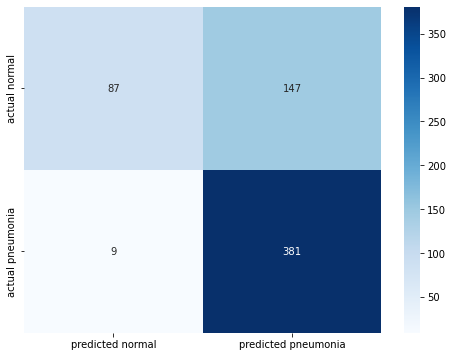

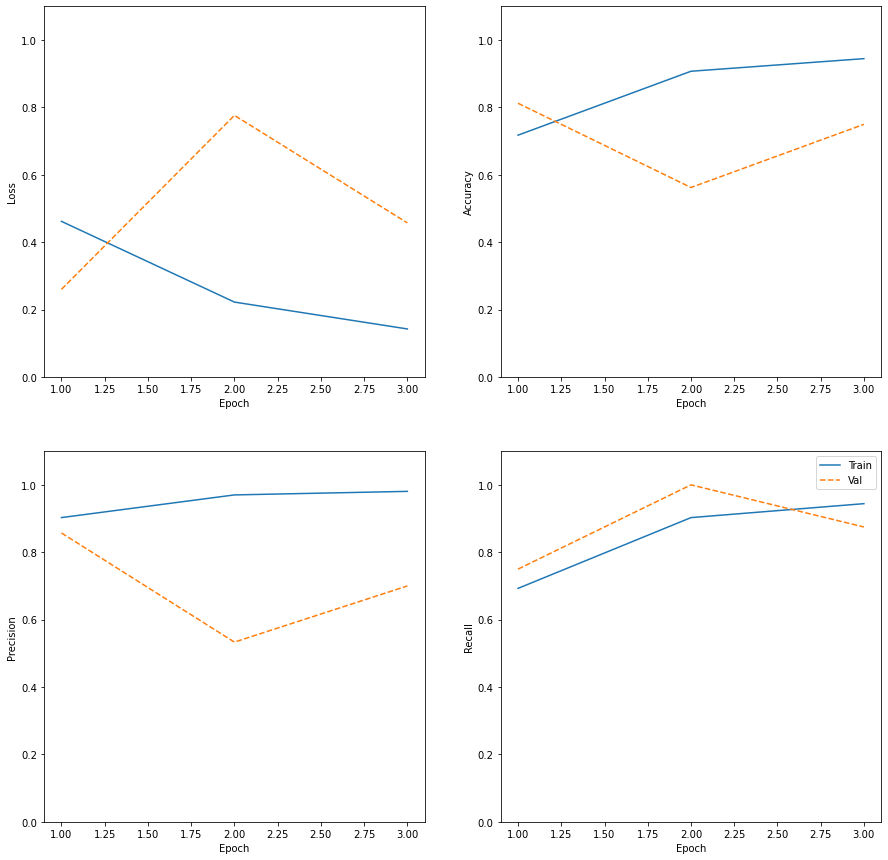

In [44]:
full_report(cnn_model_v3, cnn_model_v3_results)

## CNN Model v4

Change the optimizer to RMSProp with a learning rate of 0.01

In [46]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))    
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.RMSprop(0.01),
                  metrics=METRICS)

    return model

cnn_model_v4 = make_cnn_model()
cnn_model_v4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 30, 30, 64)     

In [47]:
EPOCHS = 10
BATCH_SIZE = 128

cnn_model_v4_results = cnn_model_v4.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 178s 4s/step - loss: 845.7430 - tp: 2132.0000 - fp: 601.0000 - tn: 748.0000 - fn: 1693.0000 - accuracy: 0.5566 - precision: 0.7801 - recall: 0.5574 - auc: 0.5572 - prc: 0.7575 - val_loss: 0.5104 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 4.0000 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_auc: 0.9375 - val_prc: 0.9565
Epoch 2/10
41/41 [==============================] - 172s 4s/step - loss: 0.5844 - tp: 3140.0000 - fp: 446.0000 - tn: 895.0000 - fn: 677.0000 - accuracy: 0.7823 - precision: 0.8756 - recall: 0.8226 - auc: 0.8000 - prc: 0.8877 - val_loss: 0.3302 - val_tp: 7.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 1.0000 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 0.9766 - val_prc: 0.9793
Epoch 3/10
41/41 [==============================] - 172s 4s/step - loss: 4.1437 - tp: 2922.0000 - fp: 498.0000 - tn: 843.0000 - fn: 895.0000 - accuracy: 0.72

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.79      0.18      0.29       234
   pneumonia       0.66      0.97      0.79       390

    accuracy                           0.67       624
   macro avg       0.73      0.58      0.54       624
weighted avg       0.71      0.67      0.60       624



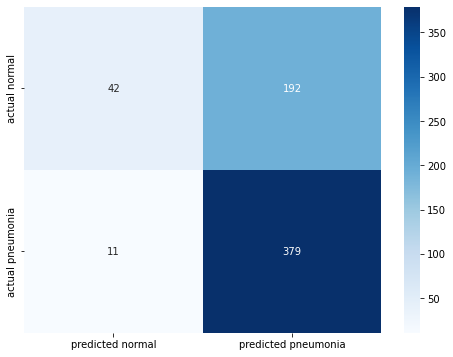

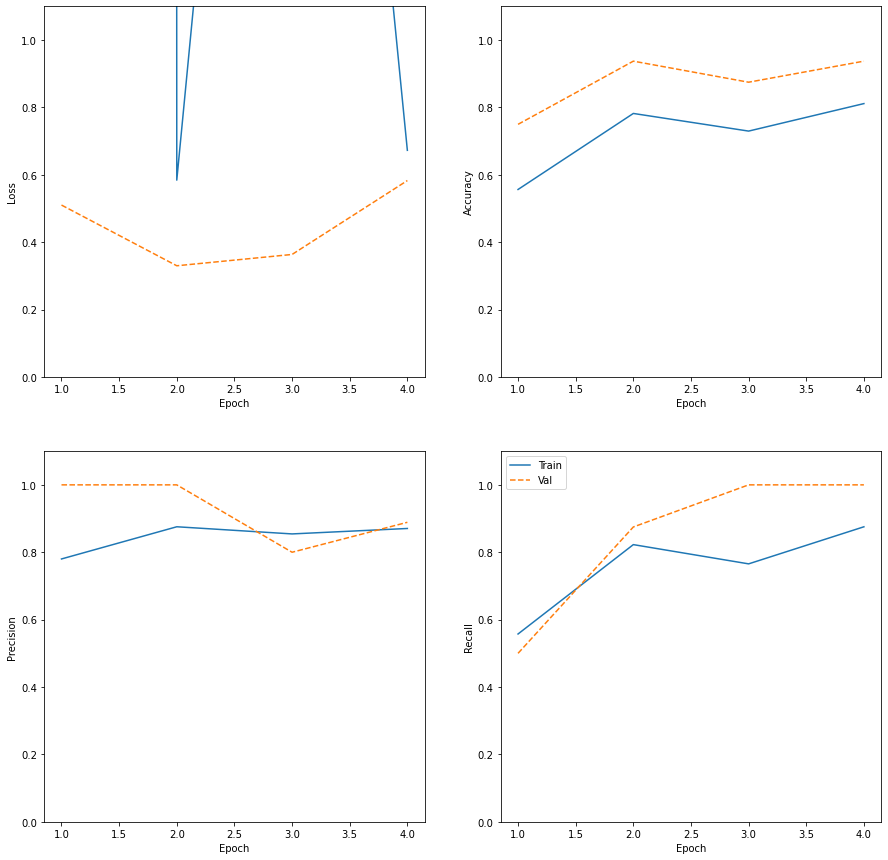

In [48]:
full_report(cnn_model_v4, cnn_model_v4_results)

## CNN model v5

Decrease the learning rate by a factor of 10.

In [49]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))    
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.RMSprop(0.001),
                  metrics=METRICS)

    return model

cnn_model_v5 = make_cnn_model()
cnn_model_v5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 30, 30, 64)     

In [50]:
EPOCHS = 10
BATCH_SIZE = 128

cnn_model_v5_results = cnn_model_v5.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 190s 5s/step - loss: 0.9368 - tp: 2362.0000 - fp: 393.0000 - tn: 956.0000 - fn: 1463.0000 - accuracy: 0.6413 - precision: 0.8574 - recall: 0.6175 - auc: 0.6881 - prc: 0.8269 - val_loss: 0.3368 - val_tp: 8.0000 - val_fp: 3.0000 - val_tn: 5.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 0.9531 - val_prc: 0.9643
Epoch 2/10
41/41 [==============================] - 184s 4s/step - loss: 0.3862 - tp: 3231.0000 - fp: 232.0000 - tn: 1109.0000 - fn: 586.0000 - accuracy: 0.8414 - precision: 0.9330 - recall: 0.8465 - auc: 0.9063 - prc: 0.9550 - val_loss: 0.6684 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 5.0000 - val_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.3750 - val_auc: 0.9844 - val_prc: 0.9853
Epoch 3/10
41/41 [==============================] - 181s 4s/step - loss: 0.2602 - tp: 3416.0000 - fp: 135.0000 - tn: 1206.0000 - fn: 401.0000 - accuracy: 0.89

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.91      0.22      0.36       234
   pneumonia       0.68      0.99      0.80       390

    accuracy                           0.70       624
   macro avg       0.80      0.60      0.58       624
weighted avg       0.77      0.70      0.64       624



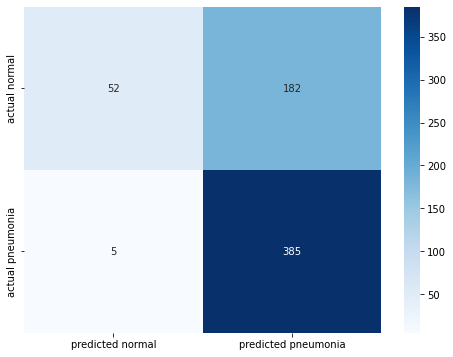

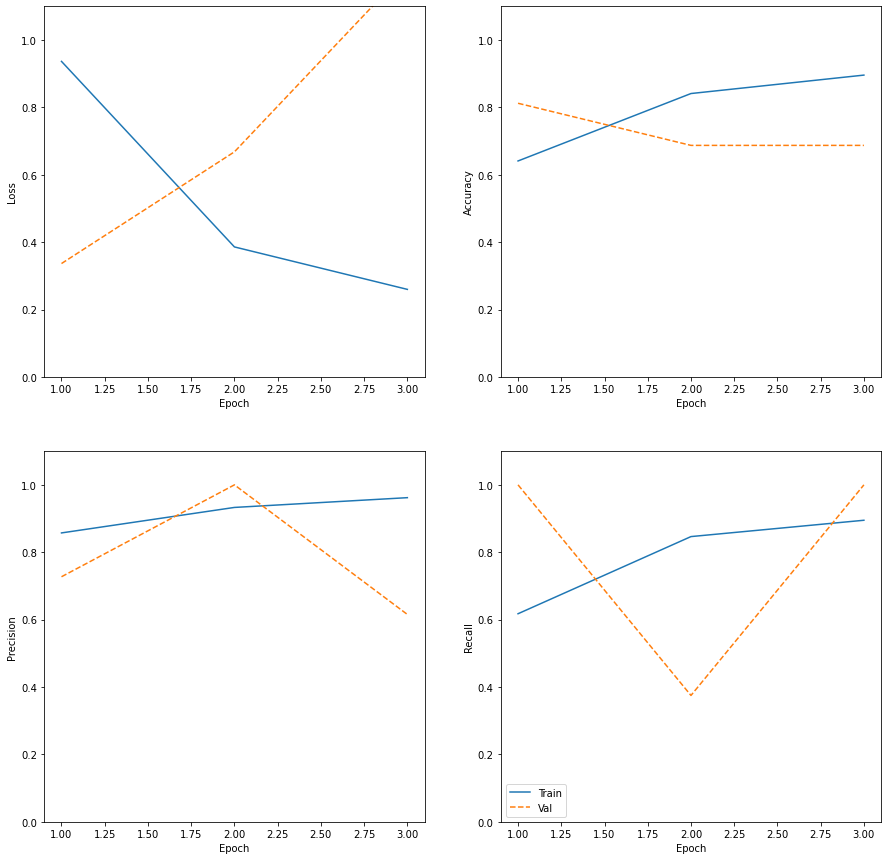

In [51]:
full_report(cnn_model_v5, cnn_model_v5_results)

## CNN model v6

So far our implementational changes have resulted in worse performing models than our second.

We are going to go back to that and change the 2nd convolutional layer to 32 from 64. Also, this version will have the class weights added into it, also different than version 2

In [52]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v6 = make_cnn_model()
cnn_model_v6.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 30, 30, 64)     

In [53]:
EPOCHS = 10
BATCH_SIZE = 128

cnn_model_v6_results = cnn_model_v6.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
41/41 [==============================] - 147s 4s/step - loss: 0.4714 - tp: 2544.0000 - fp: 222.0000 - tn: 1127.0000 - fn: 1281.0000 - accuracy: 0.7095 - precision: 0.9197 - recall: 0.6651 - auc: 0.8558 - prc: 0.9358 - val_loss: 0.3684 - val_tp: 5.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 3.0000 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.9297 - val_prc: 0.9329
Epoch 2/10
41/41 [==============================] - 157s 4s/step - loss: 0.1843 - tp: 3532.0000 - fp: 88.0000 - tn: 1253.0000 - fn: 285.0000 - accuracy: 0.9277 - precision: 0.9757 - recall: 0.9253 - auc: 0.9792 - prc: 0.9920 - val_loss: 0.5156 - val_tp: 6.0000 - val_fp: 2.0000 - val_tn: 6.0000 - val_fn: 2.0000 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8750 - val_prc: 0.8723
Epoch 3/10
41/41 [==============================] - 161s 4s/step - loss: 0.1325 - tp: 3619.0000 - fp: 63.0000 - tn: 1278.0000 - fn: 198.0000 - accuracy: 0.9494 - 

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.92      0.39      0.55       234
   pneumonia       0.73      0.98      0.84       390

    accuracy                           0.76       624
   macro avg       0.82      0.69      0.69       624
weighted avg       0.80      0.76      0.73       624



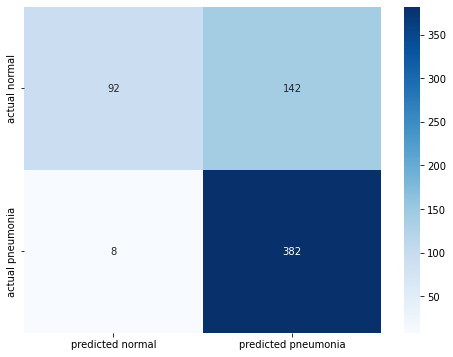

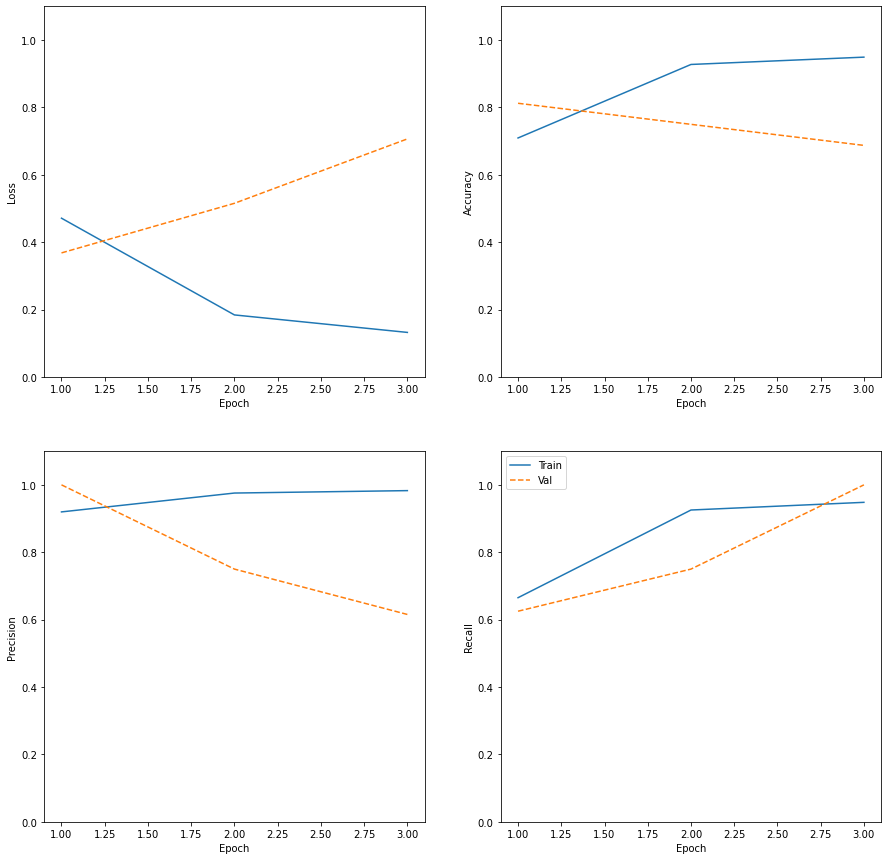

In [54]:
full_report(cnn_model_v6, cnn_model_v6_results)

## CNN model v7

Version 6 performed the best on non-pneumonia scans, at the expense of a few missed positive images. Lets try and decrease the batch size and see if that helps

In [55]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v7 = make_cnn_model()
cnn_model_v7.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 30, 30, 64)     

In [56]:
EPOCHS = 10
BATCH_SIZE = 64

cnn_model_v7_results = cnn_model_v7.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
81/81 [==============================] - 150s 2s/step - loss: 0.3173 - tp: 3195.0000 - fp: 186.0000 - tn: 1163.0000 - fn: 630.0000 - accuracy: 0.8423 - precision: 0.9450 - recall: 0.8353 - auc: 0.9361 - prc: 0.9754 - val_loss: 0.2562 - val_tp: 7.0000 - val_fp: 1.0000 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750 - val_auc: 0.9688 - val_prc: 0.9686
Epoch 2/10
81/81 [==============================] - 153s 2s/step - loss: 0.1610 - tp: 3588.0000 - fp: 80.0000 - tn: 1261.0000 - fn: 229.0000 - accuracy: 0.9401 - precision: 0.9782 - recall: 0.9400 - auc: 0.9833 - prc: 0.9931 - val_loss: 0.5571 - val_tp: 8.0000 - val_fp: 4.0000 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_auc: 0.9062 - val_prc: 0.9270
Epoch 3/10
81/81 [==============================] - 143s 2s/step - loss: 0.1167 - tp: 3667.0000 - fp: 54.0000 - tn: 1287.0000 - fn: 150.0000 - accuracy: 0.9604 - p

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.99      0.29      0.44       234
   pneumonia       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.63       624
weighted avg       0.81      0.73      0.68       624



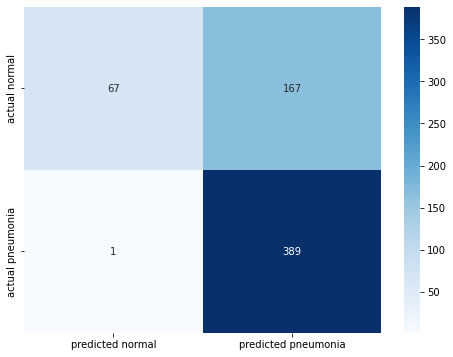

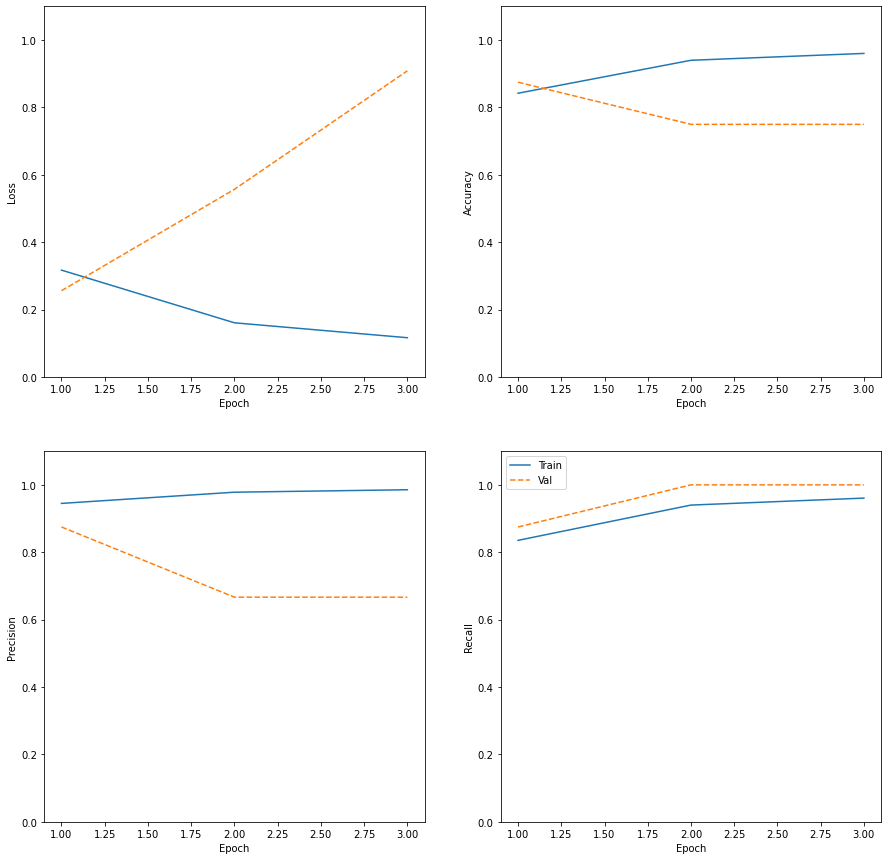

In [57]:
full_report(cnn_model_v7, cnn_model_v7_results)

## CNN model v8


Same thing but lets increase batch size to see the difference

In [60]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v8 = make_cnn_model()
cnn_model_v8.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 30, 30, 64)     

In [61]:
EPOCHS = 10
BATCH_SIZE = 256

cnn_model_v8_results = cnn_model_v8.fit(X_train, y_train,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=[early_stopping],
                                        class_weight=class_weights,
                                        validation_data=(X_val, y_val))

Epoch 1/10
21/21 [==============================] - 150s 7s/step - loss: 0.6447 - tp: 2039.0000 - fp: 396.0000 - tn: 953.0000 - fn: 1786.0000 - accuracy: 0.5783 - precision: 0.8374 - recall: 0.5331 - auc: 0.7028 - prc: 0.8607 - val_loss: 0.5393 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 4.0000 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_auc: 0.9688 - val_prc: 0.9686
Epoch 2/10
21/21 [==============================] - 147s 7s/step - loss: 0.2702 - tp: 3370.0000 - fp: 133.0000 - tn: 1208.0000 - fn: 447.0000 - accuracy: 0.8876 - precision: 0.9620 - recall: 0.8829 - auc: 0.9584 - prc: 0.9845 - val_loss: 0.3935 - val_tp: 8.0000 - val_fp: 2.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 0.9375 - val_prc: 0.9377
Epoch 3/10
21/21 [==============================] - 146s 7s/step - loss: 0.1690 - tp: 3561.0000 - fp: 83.0000 - tn: 1258.0000 - fn: 256.0000 - accuracy: 0.934

Choose which testing dataset to use for reporting
Input S for training data
Input T for test data
Input V for validation data:
t
---------------------------------------------------------------

              precision    recall  f1-score   support

      normal       0.86      0.60      0.71       234
   pneumonia       0.80      0.94      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.77      0.79       624
weighted avg       0.82      0.81      0.81       624



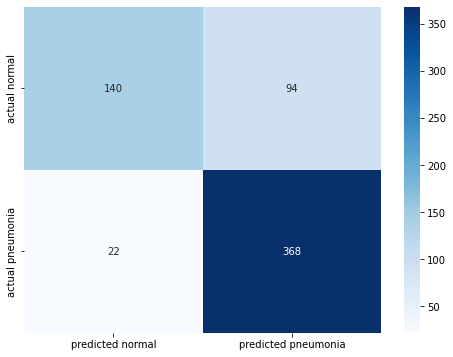

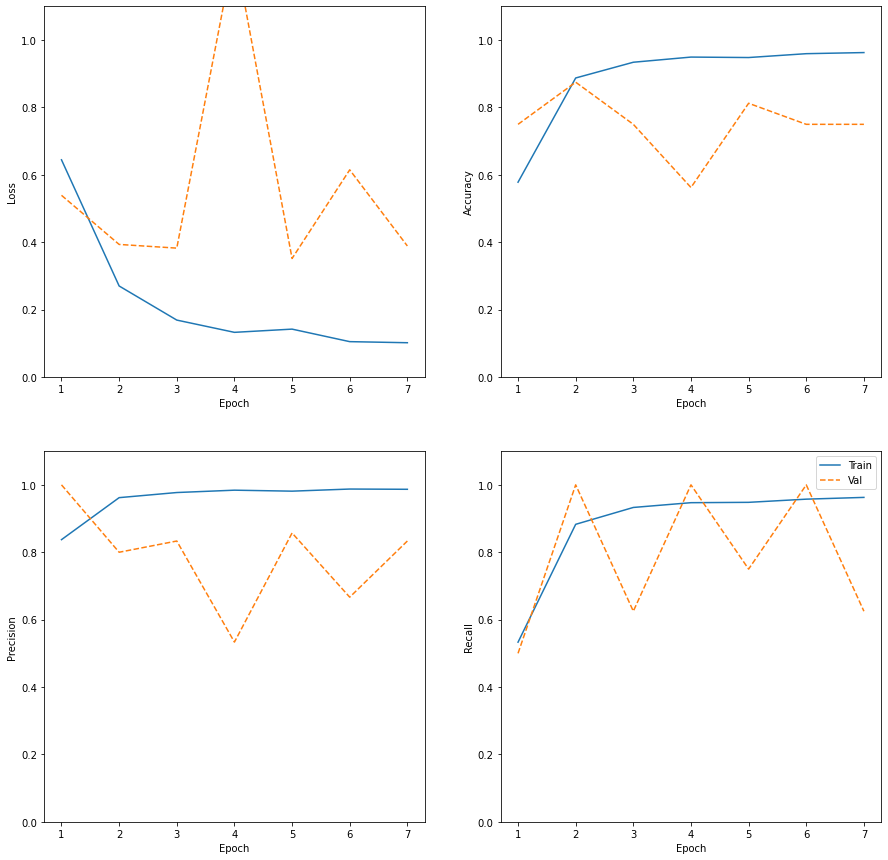

In [62]:
full_report(cnn_model_v8, cnn_model_v8_results)

## CNN model v9

Version 8 was the best one yet! Increase in total accuracy to 81%. It does come with a cost of increasing type II errors.

In [ ]:
def make_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

    return model

cnn_model_v8 = make_cnn_model()
cnn_model_v8.summary()

# Xception

### Setting up data

The Xception pretrained model requires that our images be (299, 299, 3)

In [107]:
folder_names = ['train', 'test', 'val']
label_names = ['NORMAL', 'PNEUMONIA']

all_images = []

# loop through the different combinations of folder name prefixes
for folder in folder_names:
    for label in label_names:
        # set up the path to each folder of images
        path = f'./chest_xray/{folder}/{label}'
        # create a list of the filenames in that directory
        filelist = list(listdir(path))
        # loop through each file in the folder
        for file_name in filelist:
            # set the filepath for the file in question
            filepath = path + r'/' + file_name
            # open the image
            image = Image.open(filepath).convert('RGB')
            # drop all images with height lower than 299
            if image.height < 299:
                continue    
            # resize and crop the image to 299x299
            new_image = resize_and_crop(image, new_size=299)
            # convert the image into an array
            image_array = np.asarray(new_image)
            # append all the image information to the list of images
            all_images.append((folder, label, image_array))

# set the column names
column_names = ['folder', 'label', 'image_array']
# convert the list of images to a dataframe
all_images_df = pd.DataFrame(all_images, columns=column_names)

In [108]:
all_images_df

,folder,label,image_array
0,train,NORMAL,"[[[81, 81, 81], [86, 86, 86], [89, 89, 89], [9..."
1,train,NORMAL,"[[[85, 85, 85], [86, 86, 86], [90, 90, 90], [8..."
2,train,NORMAL,"[[[83, 83, 83], [85, 85, 85], [83, 83, 83], [8..."
3,train,NORMAL,"[[[106, 106, 106], [103, 103, 103], [109, 109,..."
4,train,NORMAL,"[[[25, 25, 25], [22, 22, 22], [20, 20, 20], [1..."
...,...,...,...
5775,val,PNEUMONIA,"[[[133, 133, 133], [130, 130, 130], [126, 126,..."
5776,val,PNEUMONIA,"[[[160, 160, 160], [160, 160, 160], [153, 153,..."
5777,val,PNEUMONIA,"[[[124, 124, 124], [126, 126, 126], [128, 128,..."
5778,val,PNEUMONIA,"[[[227, 227, 227], [55, 55, 55], [64, 64, 64],..."


In [109]:
all_images_df.iloc[0]['image_array'].shape

(299, 299, 3)

In [76]:
X_groups = ['X_train', 'X_val', 'X_test']

for data in X_groups:
    new_var = f"{data}_xc"
    globals()[new_var] = keras.applications.xception.preprocess_input(globals()[data])
    
# verify shapes are accurate
print(f"Train data/target shapes: {X_train_xc.shape}, {y_train.shape}")
print(f"Test data/target shapes: {X_test_xc.shape}, {y_test.shape}")
print(f"Val data/target shapes: {X_val_xc.shape}, {y_val.shape}")

Train data/target shapes: (5158, 256, 256, 1), (5158,)
Test data/target shapes: (624, 256, 256, 1), (624,)
Val data/target shapes: (16, 256, 256, 1), (16,)


In [83]:
X_train_xc_test = np.expand_dims(X_train_xc, axis=3)

In [84]:
X_train_xc_test.shape

(5158, 256, 256, 1, 1)

## Xception model v1

In [81]:
xception_model_v1 = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="softmax",
)

83697664/83683744 [==============================] - 1s 0us/step


In [73]:


X_train_xc = keras.applications.xception.preprocess_input(X_train)


